<a href="https://colab.research.google.com/github/jnokorie/Stock-Prediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The market will go up tomorrow.


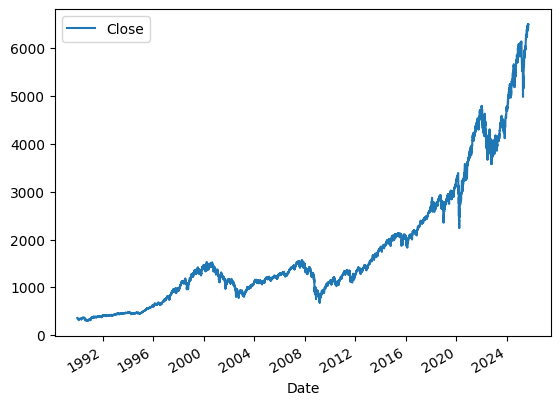

In [1]:
# Import libraries
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd

# Download historical S&P 500 (^GSPC) data from Yahoo Finance
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period='max')   # Get all available historical data
sp500

# Create target column: whether the market goes up the next day
sp500['Tomorrow'] = sp500['Close'].shift(-1)  # Shift closing prices by 1 day
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)
# 1 if tomorrow’s close is higher than today’s, else 0

# Only use data from 1990 onwards
sp500 = sp500.loc['1990-01-01':].copy()

# Quick visualization of historical prices
sp500.plot.line(y='Close')
sp500

# Define rolling horizons (lookback periods in days)
horizons = [2, 5, 60, 250, 1000]
new_predictors = []  # Will hold names of newly created predictor features

# Create features for each horizon
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    # Ratio of current price to rolling average (momentum/mean reversion signal)
    ratio_column = f'Close_Ratio_{horizon}'
    sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']

    # Count of up days over past 'horizon' days (trend indicator)
    trend_column = f'Trend_{horizon}'
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

    # Add to predictor list
    new_predictors += [ratio_column, trend_column]

# Drop missing values from rolling calculations
sp500 = sp500.dropna()

# Initialize Random Forest model
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# Function to fit model on training set and predict on test set
def predict(train, test, predictors, model):
    # Train model
    model.fit(train[predictors], train['Target'])

    # Predict probabilities instead of hard labels
    preds = model.predict_proba(test[predictors])[:, 1]

    # Apply threshold: classify as "up" if probability ≥ 0.6
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0

    # Convert predictions into a pandas Series
    preds = pd.Series(preds, index=test.index, name='Predictions')

    # Combine predictions with actual target values
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

# Store predictions from backtesting
all_predictions = []

# Function to simulate backtesting over time
def backtest(data, model, predictors, start=2500, step=250):
    # Walk forward in steps of size "step"
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()           # Training set = all data up to i
        test = data.iloc[i:(i+step)].copy()     # Test set = next "step" rows
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)     # Store predictions
    return pd.concat(all_predictions)

# Run backtest on S&P500 data
predictions = backtest(sp500, model, new_predictors)

# Check distribution of predictions (number of up vs down days predicted)
predictions['Predictions'].value_counts()

# Evaluate precision (how many predicted "ups" were actually ups)
precision_score(predictions['Target'], predictions['Predictions'])


# ------------------------------
# Predict the market direction for tomorrow
# ------------------------------

def predict_tomorrow(data, model, predictors):
    # Separate last row (latest available data) as test set
    test = data.iloc[-1:].copy()
    train = data.iloc[:-1].copy()

    # Train model on all past data
    model.fit(train[predictors], train['Target'])

    # Predict probability for the latest day
    preds = model.predict_proba(test[predictors])[:, 1]

    # Classify based on threshold (>= 0.5 = up, else down)
    preds = 1 if preds >= 0.5 else 0

    # Return interpretation of prediction
    if preds == 1:
        return "The market will go up tomorrow."
    else:
        return "The market will go down tomorrow."

# Call the function to predict tomorrow's market movement
print(predict_tomorrow(sp500, model, new_predictors))
